In [1]:
using PyCall
rasterio = pyimport("rasterio");

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


# Load Data

In [2]:
f = open("dem_path.txt")
filename = readlines(f)[1]
dataset = rasterio.open(filename);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [3]:
DEM = dataset.read(1);

In [4]:
transform = dataset.get_transform()

6-element Array{Float64,1}:
  5.0                  
  0.0008333333333333334
  0.0                  
 60.0                  
  0.0                  
 -0.0008333333333333334

### Calc Lat long for DEM

In [5]:
rows = collect(1:dataset.height);
columns = collect(1:dataset.width);
lon = transform[1] .+rows .*transform[2];
lat  = transform[4] .+columns .*transform[6];

### Crop DEM to coords
found some place in annotation

In [6]:
lat_max = 5.666818777336966e+01
lon_max = 8.692126035601964e+00;
lat_min = 5.514243624845066e+01
lon_min = 6.863612098279713e+00;

In [7]:
index1 = lat_min .<lat.< lat_max;
index2 = lon_min .<lon.< lon_max;

In [8]:
test = DEM[index1,index2];
lat = lat[index1]
lon = lon[index2];

In [9]:
### TO elipsoidal 

test = test .+ 39;

### Remove NaN values

In [10]:
test[test .== (-32768+ 39)] .= 10;

### Show DEM

In [11]:
using Images
using Statistics

┌ Info: Recompiling stale cache file /Users/eyu/.julia/compiled/v1.1/Images/H8Vxc.ji for Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1184


In [12]:
Show_img = abs.(copy(test))
Show_img = Show_img./quantile(reshape(Show_img, :), 0.98);

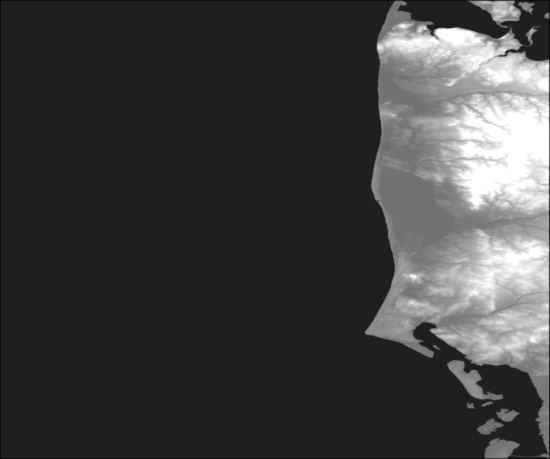

In [13]:
Gray.(Show_img)

### Create 2d array with points

In [14]:
lat_matrix = Array{Float64}(undef, length(lat), length(lon))
lon_matrix = Array{Float64}(undef,length(lat), length(lon))

for i = 1:length(lat)
    for j = 1:length(lon)
        lat_matrix[i,j] = lat[i]
        lon_matrix[i,j] = lon[j]
    end
end   

In [15]:
llh = hcat(reshape(lat_matrix,:),reshape(lon_matrix,:),reshape(test,:));

### Transform to sat coordinates

In [16]:
include("llh2sali.jl")
include("load_pod.jl")
include("load_s1slc_ann.jl");

In [17]:
f = open("ann_path.txt")
path = readlines(f)
sar_parameters = load_s1slc_ann(path[1])

f = open("POD_path.txt")
path = readlines(f)
osv,t_sv = load_pod(path[1],sar_parameters["t_0"]);

In [18]:
sali = llh2sali(llh, osv, t_sv, sar_parameters);

### Crop only points in image

In [55]:
sali_subset = sali;
z = reshape(test,:);

### Display transformed DEM points
## Warning:
### Heavy on the browser. Increase step to >1000 to make it easier

In [20]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [21]:
z[60 .<z] .= 60 ;

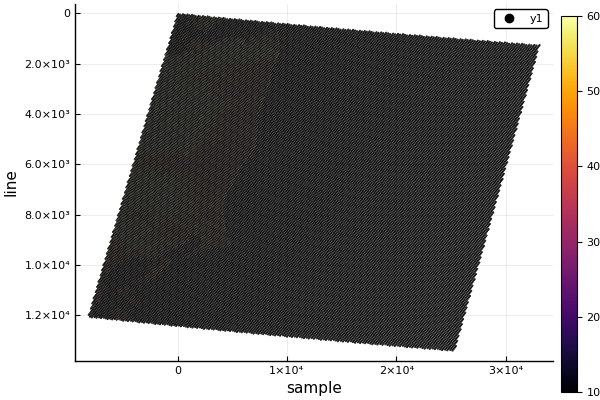

In [24]:
steps= 100
scatter(sali_subset[1:steps:end,2],sali_subset[1:steps:end,1],
    zcolor=z[1:steps:end],
    yaxis = ("line", :flip),xaxis = ("sample"),
    markersize=0.5)